In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('insurance_data.csv')

In [4]:
print(data.shape)

(1340, 11)


In [5]:
data.head(5)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [6]:
data.tail(5)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
1335,1335,1336,44.0,female,35.5,88,Yes,0,Yes,northwest,55135.40
1336,1336,1337,59.0,female,38.1,120,No,1,Yes,northeast,58571.07
1337,1337,1338,30.0,male,34.5,91,Yes,3,Yes,northwest,60021.40
1338,1338,1339,37.0,male,30.4,106,No,0,Yes,southeast,62592.87
1339,1339,1340,30.0,female,47.4,101,No,0,Yes,southeast,63770.43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


In [8]:
def find_duplicates(data):
    seen = set()
    duplicates = set()

    for item in data:
        if item in seen:
            duplicates.add(item)
        else:
            seen.add(item)

    return list(duplicates)
duplicates = find_duplicates(data)
print("Duplicates:", duplicates)

Duplicates: []


In [9]:
print ("Rows     : " , data.shape[0])
print ("Columns  : " , data.shape[1])
print ("\nFeatures : \n", data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n", data.nunique())

Rows     :  1340
Columns  :  11

Features : 
 ['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure', 'diabetic', 'children', 'smoker', 'region', 'claim']

Missing values :   8

Unique values :  
 index            1340
PatientID        1340
age                43
gender              2
bmi               275
bloodpressure      61
diabetic            2
children            6
smoker              2
region              4
claim            1337
dtype: int64


In [10]:
data = data.drop(['index','PatientID'], axis=1)

In [11]:
missing_values = data.isnull().sum()

print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64


In [12]:
age_mean = data['age'].mean()
data['age'].fillna(age_mean, inplace=True)

region_mode = data['region'].mode().iloc[0]
data['region'].fillna(region_mode, inplace=True)

data.rename(columns={'gender': 'sex'}, inplace=True)

data.rename(columns={'bloodpressure': 'bp'}, inplace=True)

data.sex=data['sex'].astype("category")
data.diabetic=data['diabetic'].astype("category")
data.smoker=data['smoker'].astype("category")
data.region=data['region'].astype("category")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1340 non-null   float64 
 1   sex       1340 non-null   category
 2   bmi       1340 non-null   float64 
 3   bp        1340 non-null   int64   
 4   diabetic  1340 non-null   category
 5   children  1340 non-null   int64   
 6   smoker    1340 non-null   category
 7   region    1340 non-null   category
 8   claim     1340 non-null   float64 
dtypes: category(4), float64(3), int64(2)
memory usage: 58.3 KB


In [13]:
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 35, 55, 100], labels=['child', 'young adult', 'middle-aged', 'senior'])
print(data[['age', 'age_group']].head())

         age    age_group
0  39.000000  middle-aged
1  24.000000  young adult
2  38.078652  middle-aged
3  38.078652  middle-aged
4  38.078652  middle-aged


In [14]:
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['underweight', 'normal weight', 'overweight', 'obese'])
print(data[['bmi', 'bmi_category']].head())

    bmi   bmi_category
0  23.2  normal weight
1  30.1          obese
2  33.3          obese
3  33.7          obese
4  34.1          obese


In [15]:
categories = {
    'Normal': (0, 120),
    'Elevated': (120, 130),
    'Hypertension Stage 1': (130, 140),
    'Hypertension Stage 2': (140, float('inf'))
}

def categorize_bp(bp):
    for category, (min_value, max_value) in categories.items():
        if min_value <= bp < max_value:
            return category
    return 'Unknown'

data['bp_category'] = data['bp'].apply(categorize_bp)

print(data[['bp', 'bp_category']].head())

    bp bp_category
0   91      Normal
1   87      Normal
2   82      Normal
3   80      Normal
4  100      Normal


In [16]:
column_order = ['age', 'age_group', 'sex', 'bmi', 'bmi_category', 'bp', 'bp_category', 'diabetic', 'children', 'smoker', 'region', 'claim']

data = data[column_order]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           1340 non-null   float64 
 1   age_group     1340 non-null   category
 2   sex           1340 non-null   category
 3   bmi           1340 non-null   float64 
 4   bmi_category  1340 non-null   category
 5   bp            1340 non-null   int64   
 6   bp_category   1340 non-null   object  
 7   diabetic      1340 non-null   category
 8   children      1340 non-null   int64   
 9   smoker        1340 non-null   category
 10  region        1340 non-null   category
 11  claim         1340 non-null   float64 
dtypes: category(6), float64(3), int64(2), object(1)
memory usage: 71.8+ KB


In [17]:
data.describe(include='category')

,age_group,sex,bmi_category,diabetic,smoker,region
count,1340,1340,1340,1340,1340,1340
unique,4,2,4,2,2,4
top,middle-aged,male,obese,No,No,southeast
freq,653,678,708,698,1066,446


In [19]:
categorical_columns = data.select_dtypes(['category']).columns
num_rows_to_display = 10
for col in categorical_columns:

    value_counts = data[col].value_counts()

    percentages = (value_counts / len(data) * 100).round(2)

    summary = pd.DataFrame({'Counts': value_counts, 'Percentages': percentages})

    summary_to_display = summary.head(num_rows_to_display)

    print(f" {col}:")
    print(summary_to_display)
    print("\n")

 age_group:
             Counts  Percentages
middle-aged     653        48.73
young adult     572        42.69
senior           99         7.39
child            16         1.19


 sex:
        Counts  Percentages
male       678         50.6
female     662         49.4


 bmi_category:
               Counts  Percentages
obese             708        52.84
overweight        389        29.03
normal weight     222        16.57
underweight        21         1.57


 diabetic:
     Counts  Percentages
No      698        52.09
Yes     642        47.91


 smoker:
     Counts  Percentages
No     1066        79.55
Yes     274        20.45


 region:
           Counts  Percentages
southeast     446        33.28
northwest     349        26.04
southwest     314        23.43
northeast     231        17.24




In [20]:
data.describe()

,age,bmi,bp,children,claim
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,38.078652,30.668955,94.157463,1.093284,13252.745642
std,11.082175,6.106735,11.434712,1.205334,12109.609288
min,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,47.000000,34.700000,99.000000,2.000000,16604.305000
max,60.000000,53.100000,140.000000,5.000000,63770.430000


In [21]:
numeric_columns = data.select_dtypes(include=[int, float])
means = numeric_columns.mean()

print(means)

age            38.078652
bmi            30.668955
bp             94.157463
children        1.093284
claim       13252.745642
dtype: float64


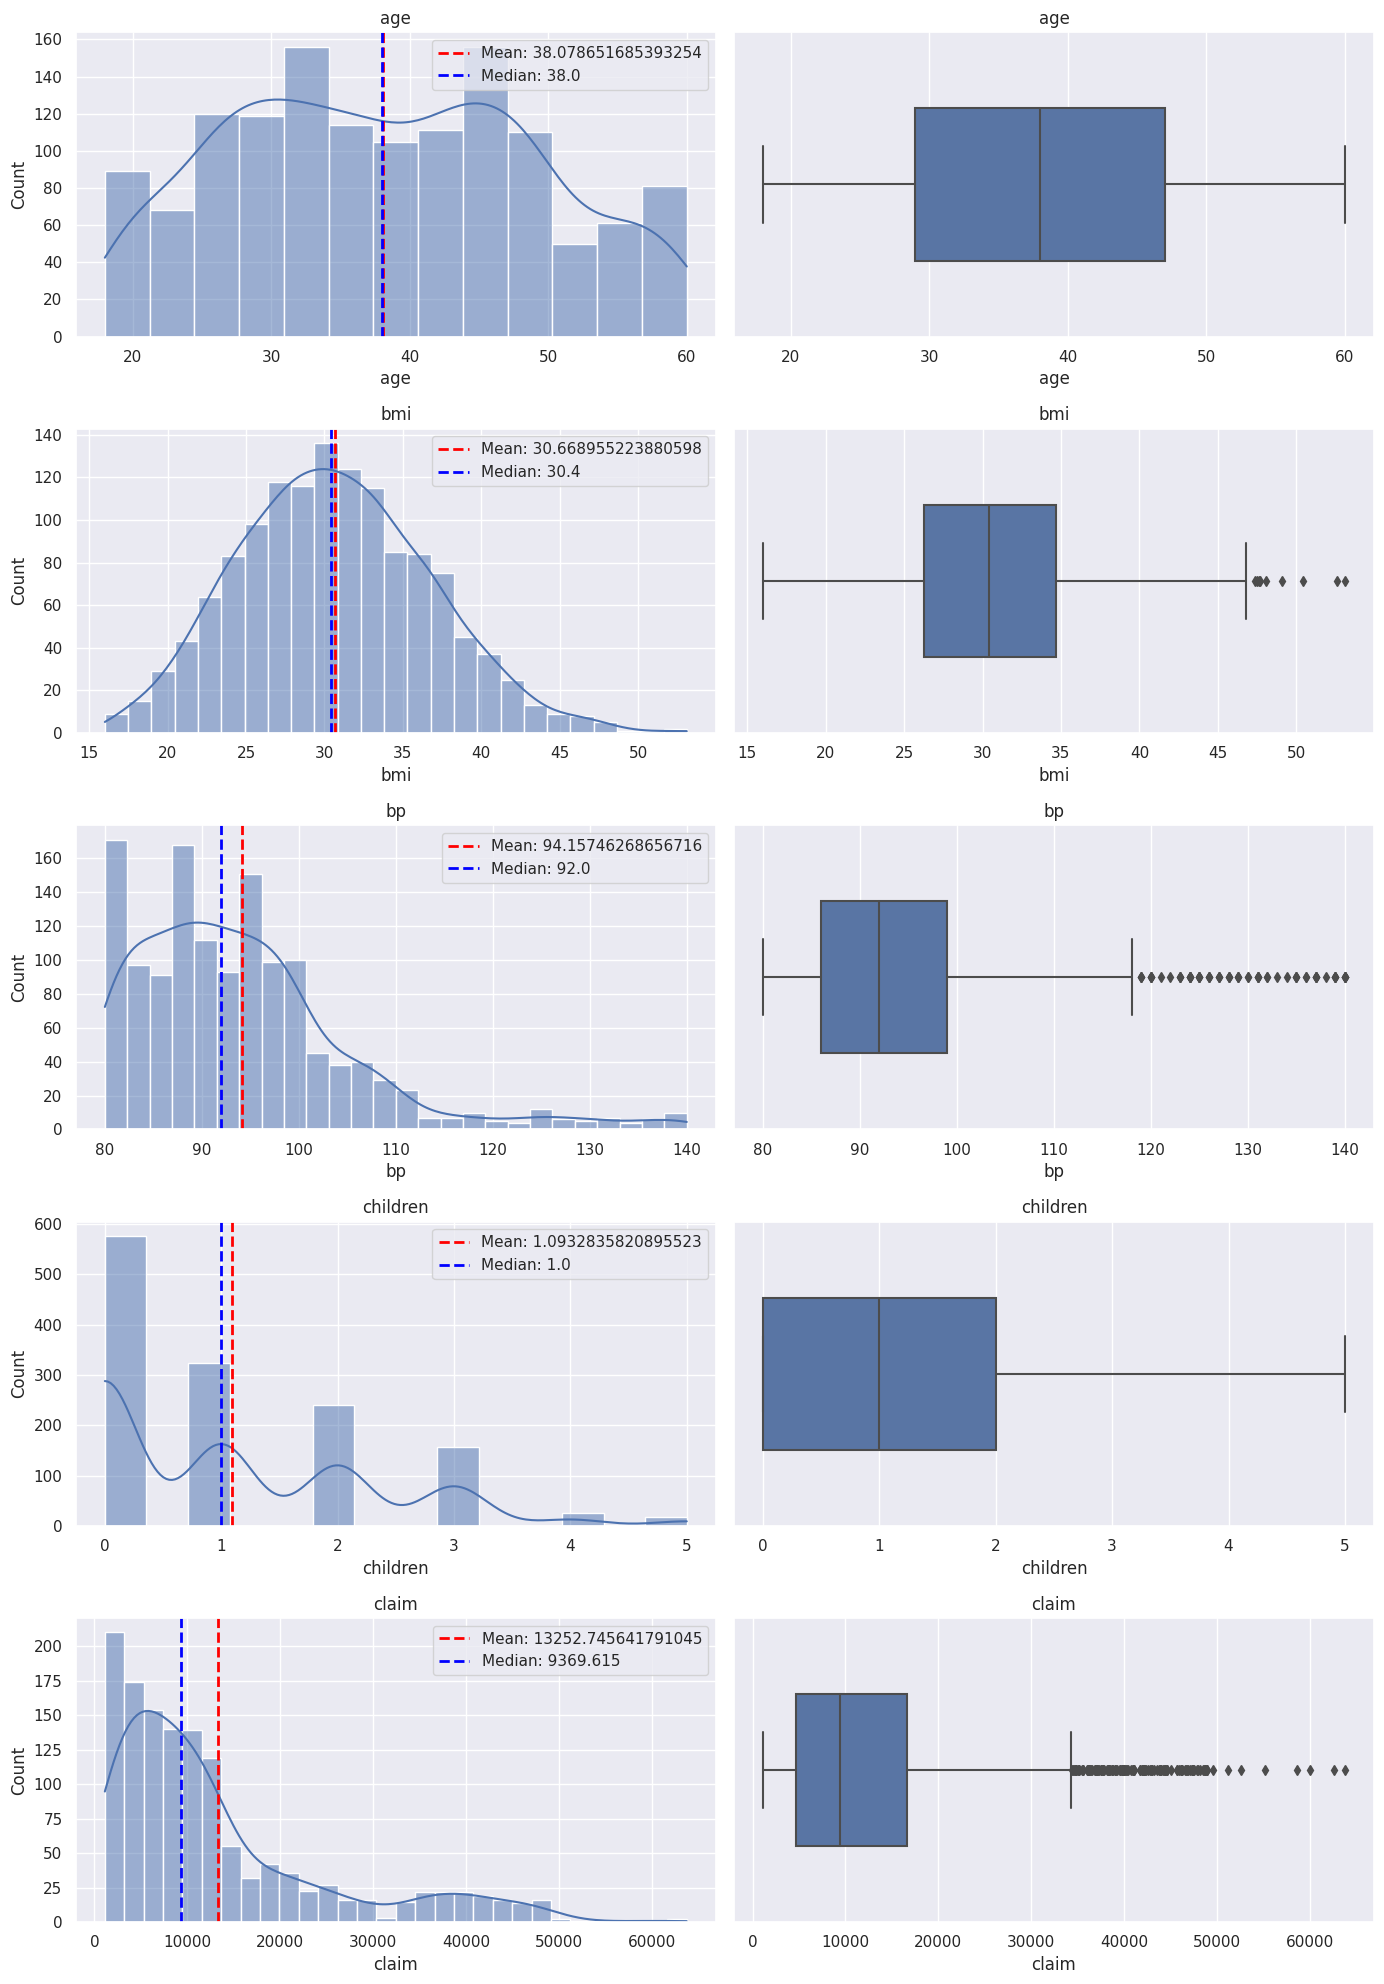

In [23]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(14, 4 * len(numeric_columns)))

for i, column in enumerate(numeric_columns):
   sns.histplot(data=data, x=column, kde=True, ax=axes[i, 0])
   axes[i, 0].set_title(f'{column}')
   mean = data[column].mean()
   median = data[column].median()
   axes[i, 0].axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean}')
   axes[i, 0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median}')
   axes[i, 0].legend()
   sns.boxplot(x=data[column], ax=axes[i, 1], width=0.5)
   axes[i, 1].set_title(f'{column}')

plt.tight_layout()
plt.show()

In [25]:
def bar_perc(plot, feature):
    total = len(feature) # length of the column
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)

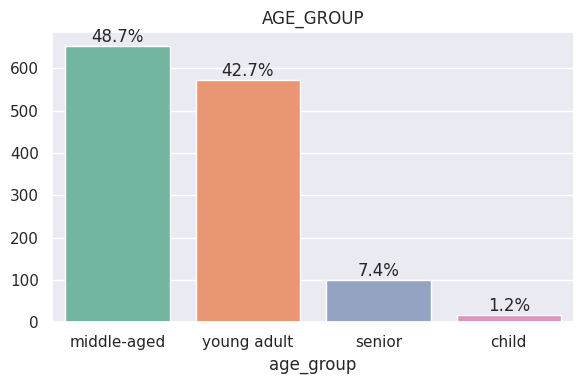

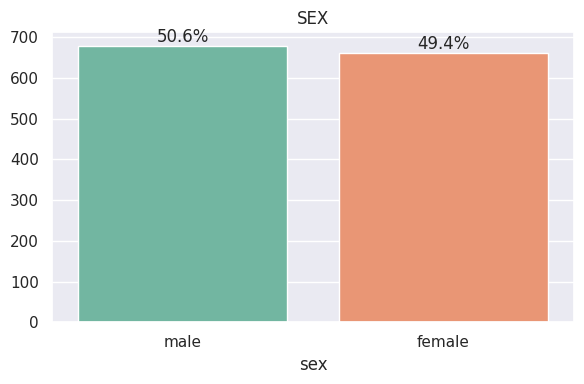

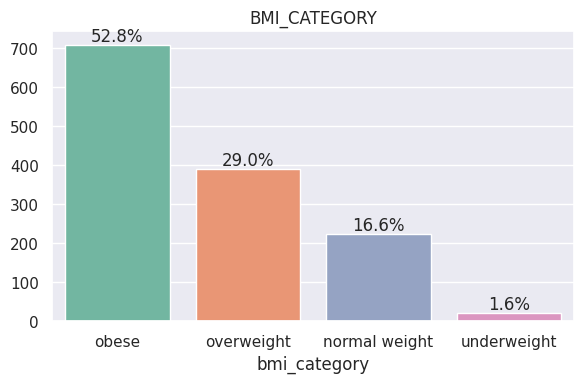

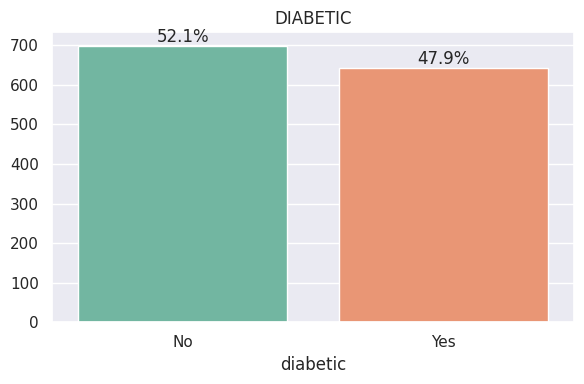

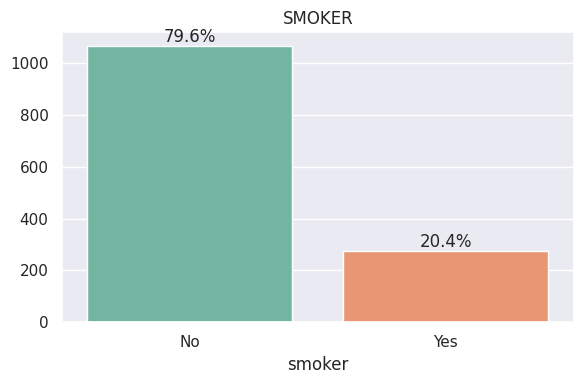

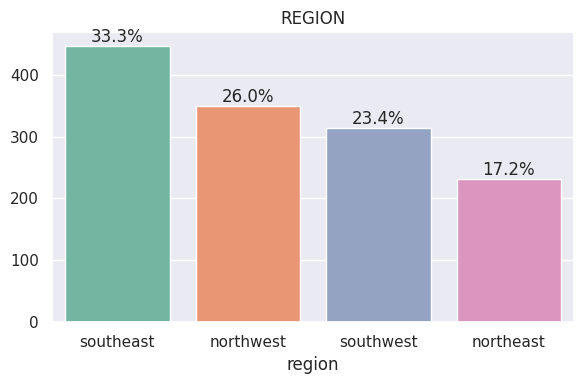

In [26]:
custom_palette = sns.color_palette("Set2")
list_col = data.select_dtypes(['category']).columns
for i, col in enumerate(list_col):
    fig, ax = plt.subplots(figsize=(6, 4))
    order = data[col].value_counts(ascending=False).index
    ax_count = sns.countplot(x=col, data=data, order=order, ax=ax, palette=custom_palette)
    ax_count.set_title(col.upper())
    ax_count.set_ylabel('')
    total = len(data[col])
    for p in ax_count.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax_count.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()

    plt.show()


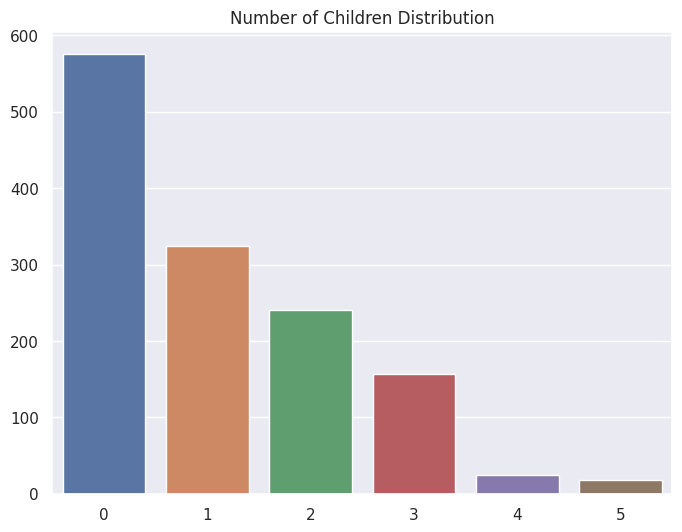

In [27]:
children_counts = data['children'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=children_counts.index, y=children_counts.values)
plt.title('Number of Children Distribution')
plt.show()

               age       bmi        bp  children     claim
age       1.000000 -0.041919 -0.060247 -0.025507 -0.027856
bmi      -0.041919  1.000000  0.143544  0.012092  0.197401
bp       -0.060247  0.143544  1.000000 -0.031682  0.531341
children -0.025507  0.012092 -0.031682  1.000000  0.069233
claim    -0.027856  0.197401  0.531341  0.069233  1.000000


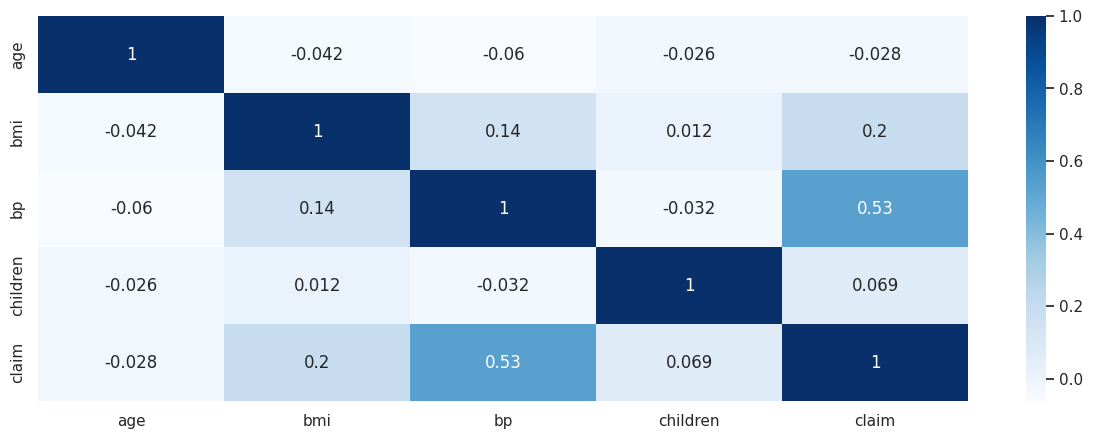

In [28]:
numeric_data = data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()
numeric_data = data.select_dtypes(include=['number'])

plt.figure(figsize=(15, 5))
sns.heatmap(numeric_data.corr(), annot=True, cmap="Blues")
print(correlation_matrix)
plt.show()

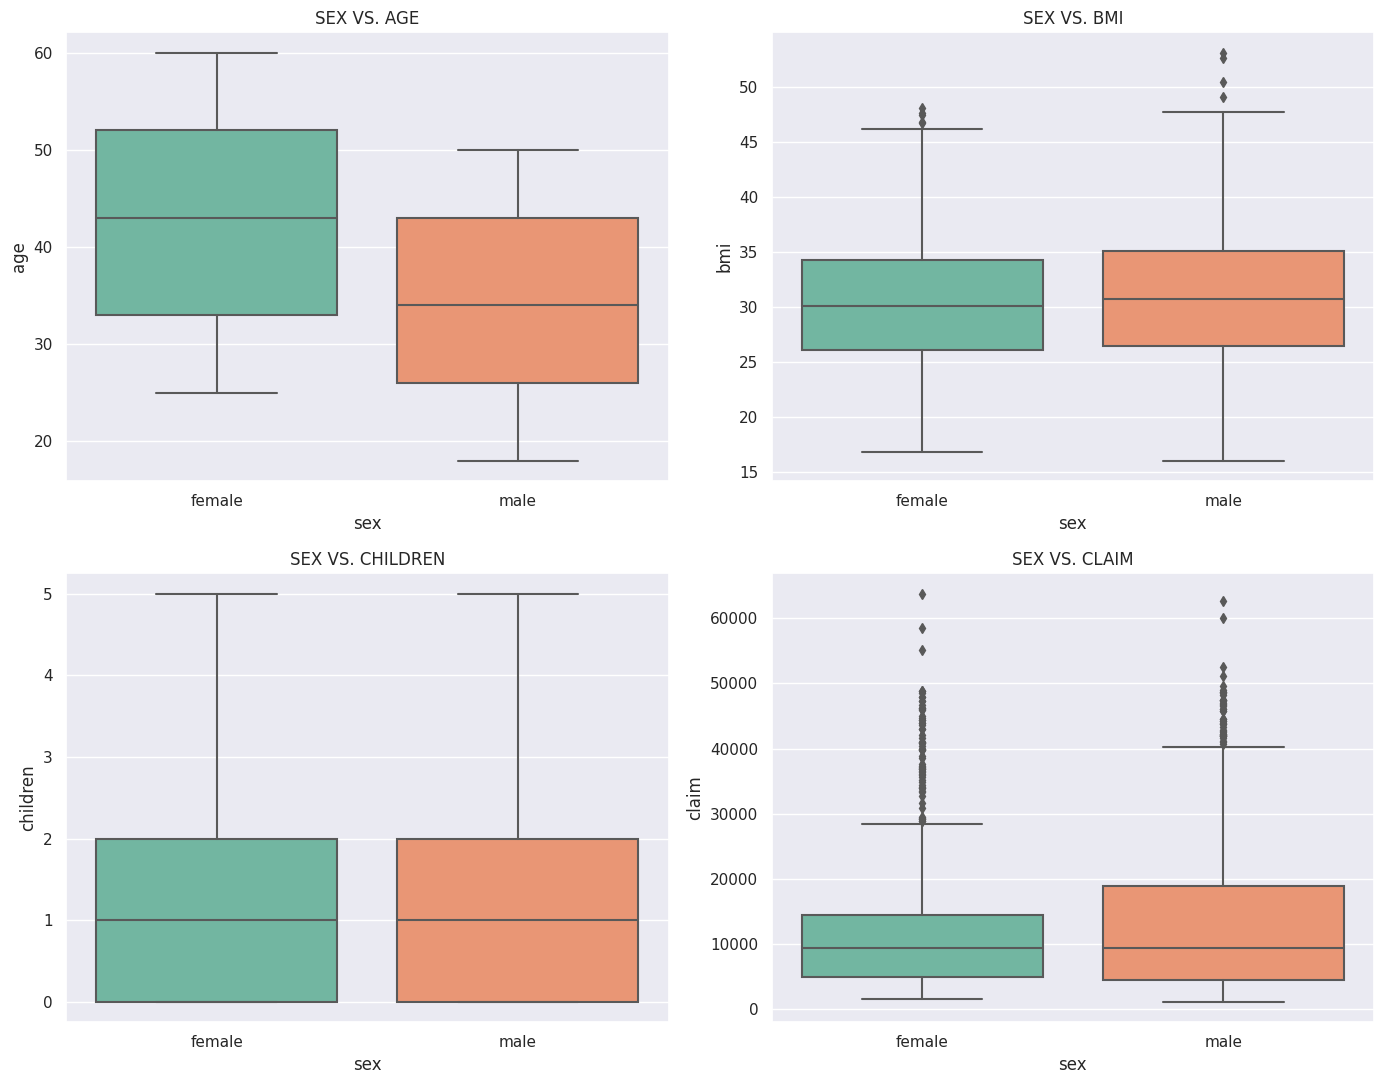

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

sns.boxplot(x='sex', y='age', data=data, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('SEX VS. AGE')

sns.boxplot(x='sex', y='bmi', data=data, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('SEX VS. BMI')

sns.boxplot(x='sex', y='children', data=data, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('SEX VS. CHILDREN')

sns.boxplot(x='sex', y='claim', data=data, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('SEX VS. CLAIM')

plt.tight_layout()
plt.show()

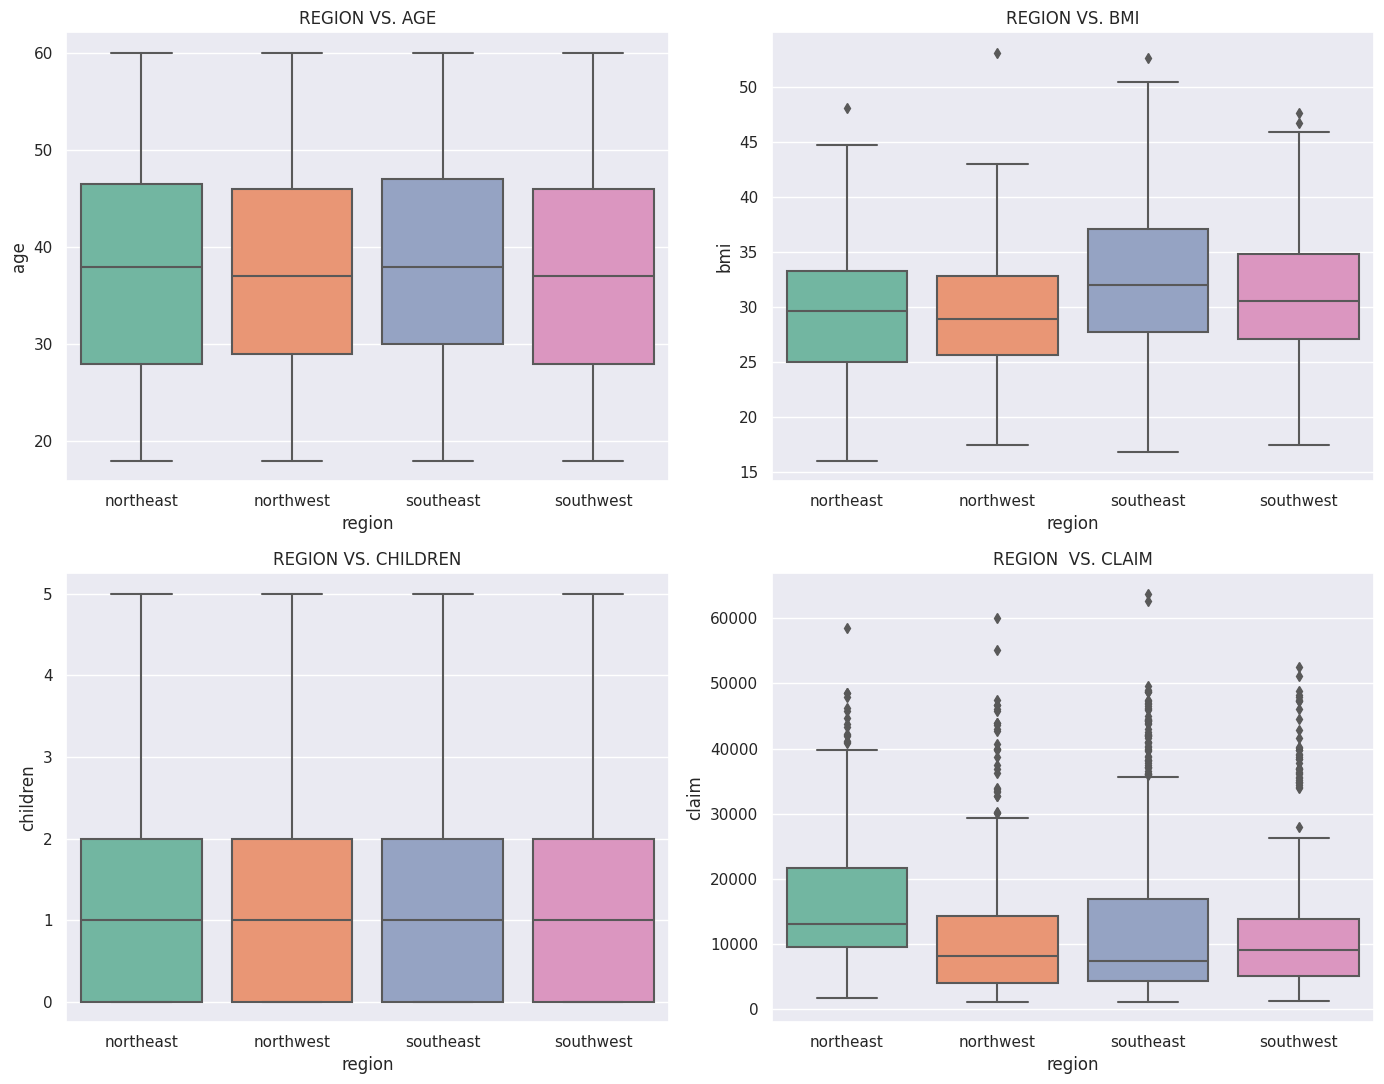

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

sns.boxplot(x='region', y='age', data=data, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('REGION VS. AGE')

sns.boxplot(x='region', y='bmi', data=data, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('REGION VS. BMI')

sns.boxplot(x='region', y='children', data=data, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('REGION VS. CHILDREN')

sns.boxplot(x='region', y='claim', data=data, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('REGION  VS. CLAIM')

plt.tight_layout()
plt.show()

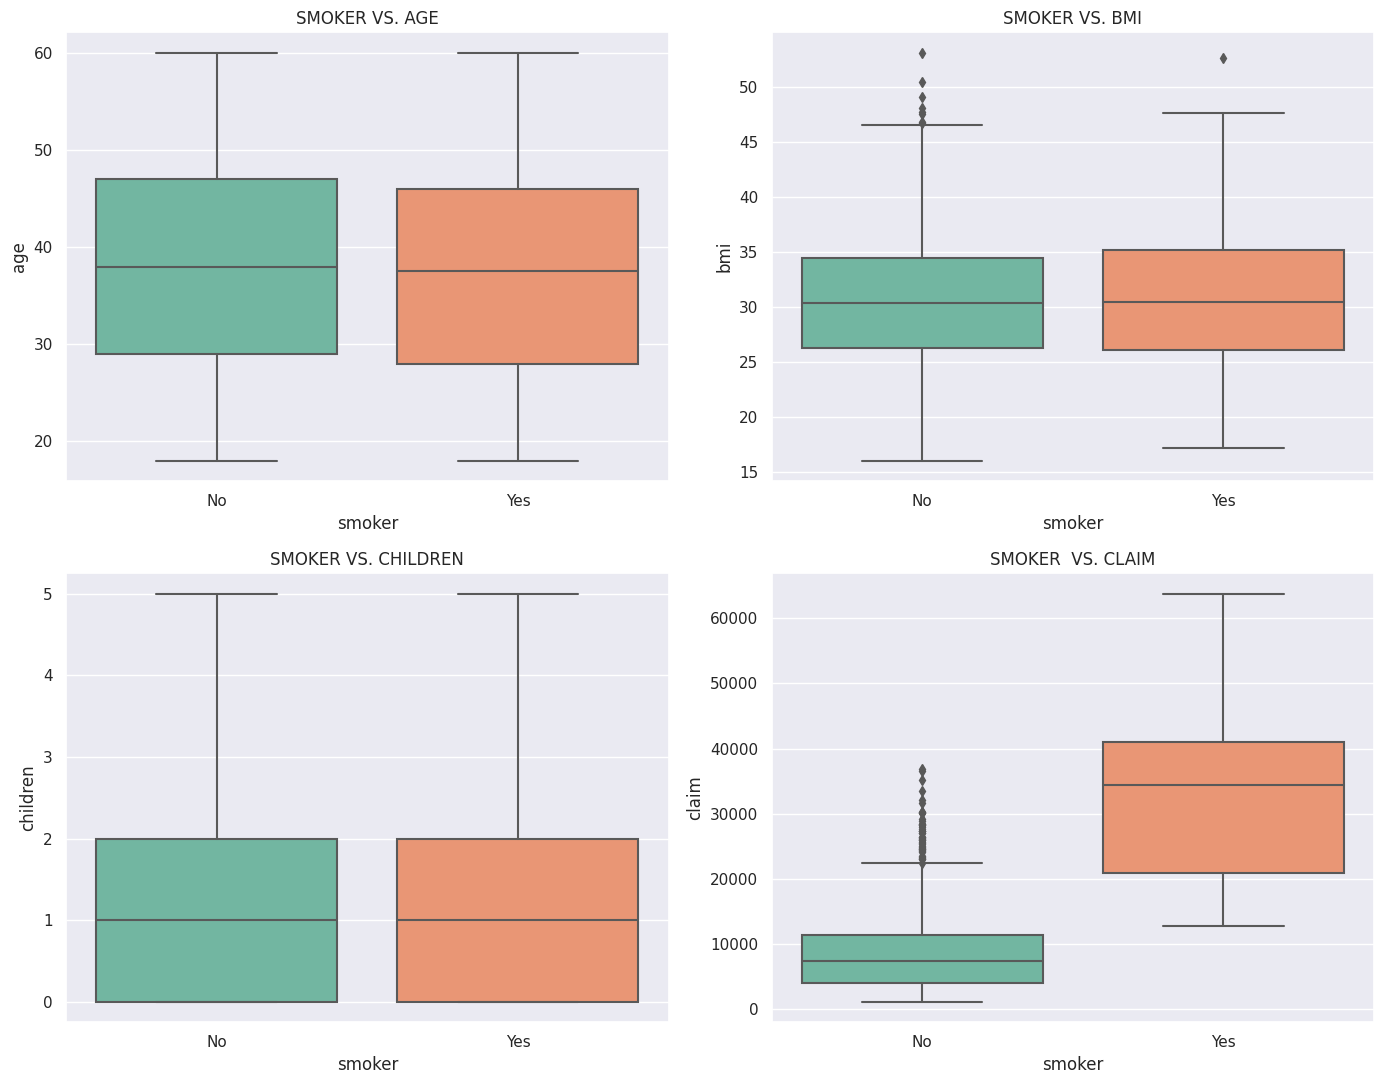

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

sns.boxplot(x='smoker', y='age', data=data, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('SMOKER VS. AGE')

sns.boxplot(x='smoker', y='bmi', data=data, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('SMOKER VS. BMI')

sns.boxplot(x='smoker', y='children', data=data, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('SMOKER VS. CHILDREN')

sns.boxplot(x='smoker', y='claim', data=data, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('SMOKER  VS. CLAIM')
plt.tight_layout()
plt.show()

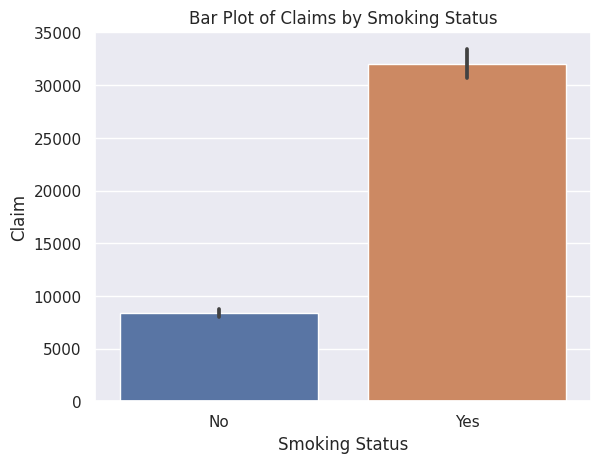

In [32]:
sns.barplot(x='smoker', y='claim', data=data)
plt.title("Bar Plot of Claims by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Claim")
plt.show()

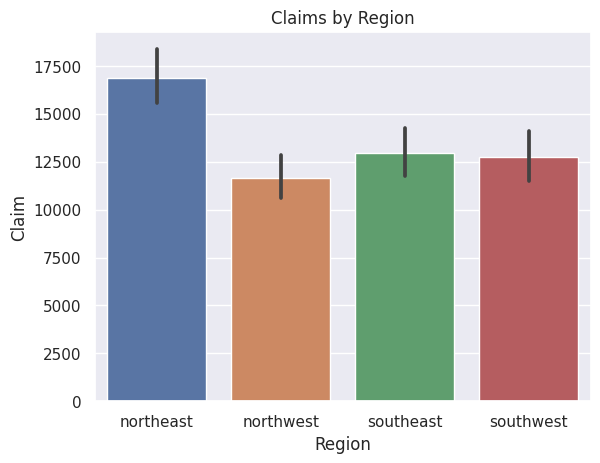

In [33]:
sns.barplot(x='region', y='claim', data=data)
plt.title("Claims by Region")
plt.xlabel("Region")
plt.ylabel("Claim")
plt.show()

[Text(0.5, 1.0, 'Number of Children vs Claim')]

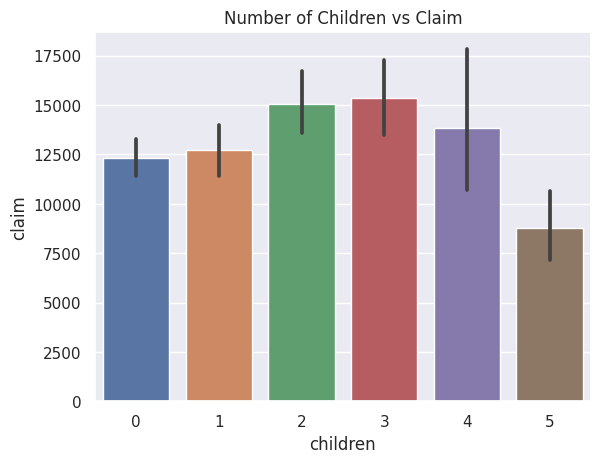

In [34]:
sns.barplot(x=data.children,y=data.claim).set(title="Number of Children vs Claim")

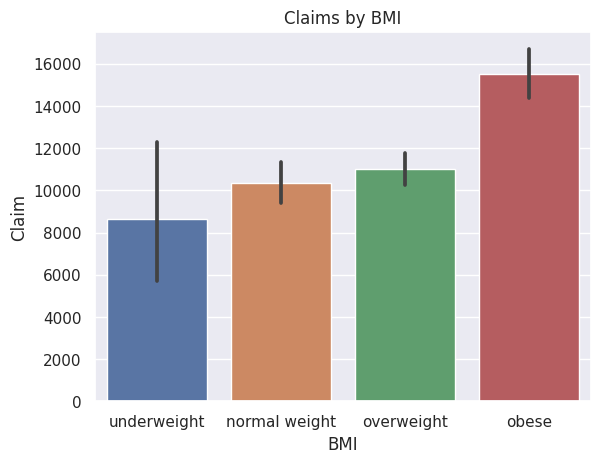

In [35]:
sns.barplot(x='bmi_category', y='claim', data=data)
plt.title("Claims by BMI")
plt.xlabel("BMI")
plt.ylabel("Claim")
plt.show()

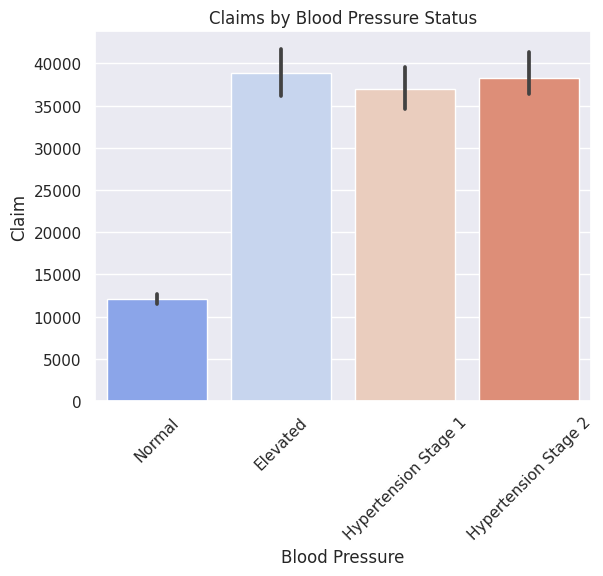

In [36]:
custom_palette = sns.color_palette("coolwarm", n_colors=4)

sns.barplot(x='bp_category', y='claim', data=data, palette=custom_palette)
plt.title("Claims by Blood Pressure Status")
plt.xlabel("Blood Pressure")
plt.ylabel("Claim")

plt.xticks(rotation=45)
plt.show()

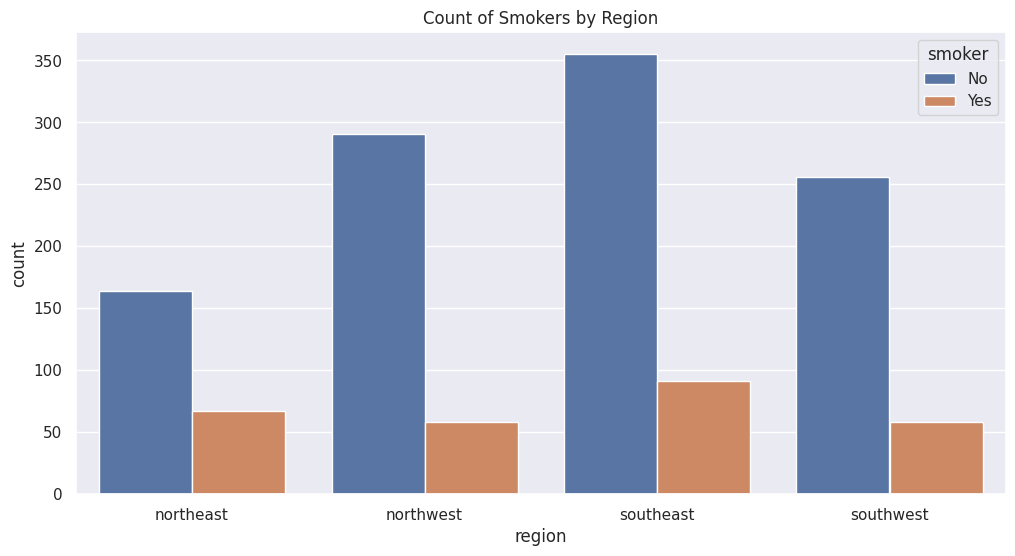

In [37]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='region', hue='smoker')
plt.title('Count of Smokers by Region')
plt.show()

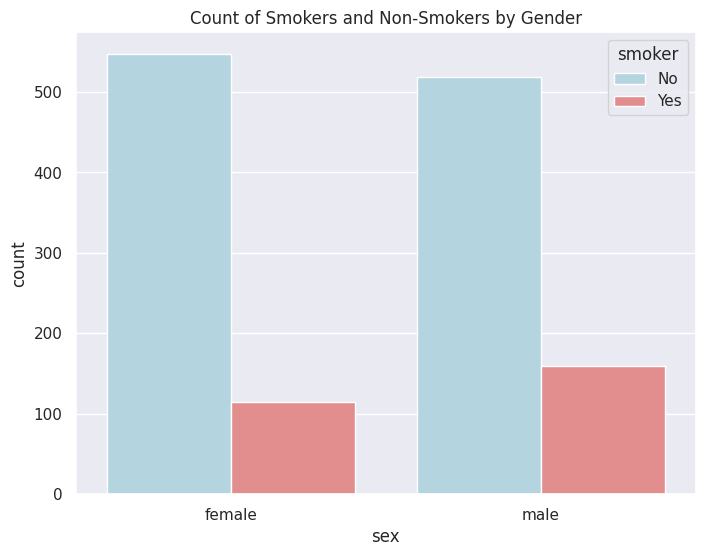

In [38]:
custom_palette = {"Yes": "lightcoral", "No": "lightblue"}
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='sex', hue='smoker', palette=custom_palette)
plt.title('Count of Smokers and Non-Smokers by Gender')
plt.show()

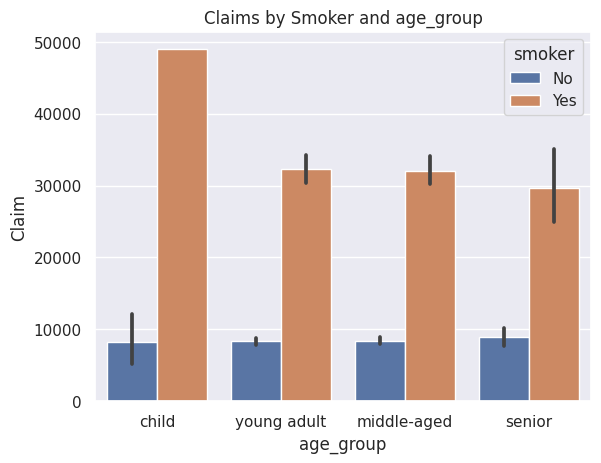

In [39]:
sns.barplot(x='age_group', hue='smoker', y='claim', data=data)
plt.title("Claims by Smoker and age_group")
plt.xlabel("age_group")
plt.ylabel("Claim")
plt.show()

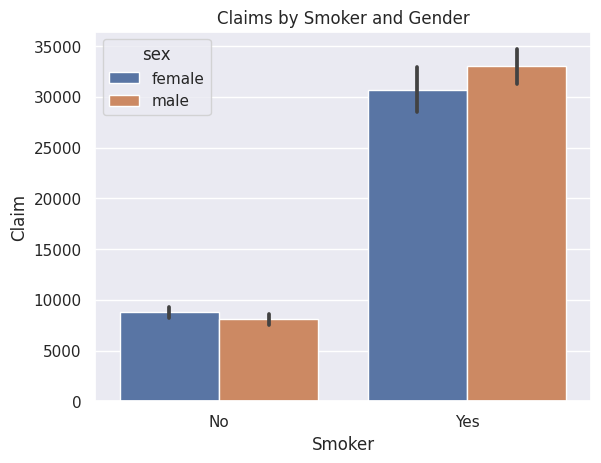

In [40]:
sns.barplot(x='smoker', hue='sex', y='claim', data=data)
plt.title("Claims by Smoker and Gender")
plt.xlabel("Smoker")
plt.ylabel("Claim")
plt.show()

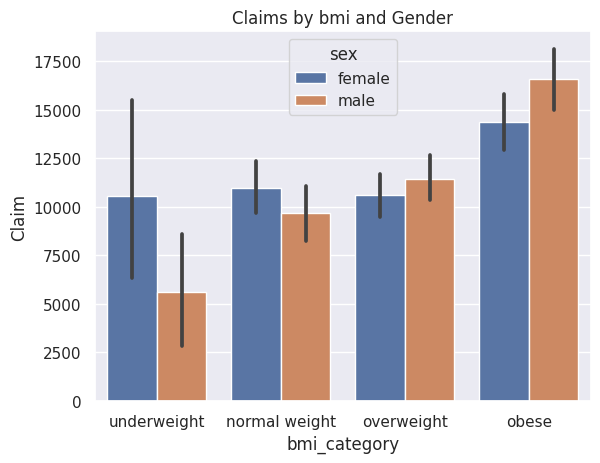

In [41]:
sns.barplot(x='bmi_category', hue='sex', y='claim', data=data)
plt.title("Claims by bmi and Gender")
plt.xlabel("bmi_category")
plt.ylabel("Claim")
plt.show()